In [55]:
import pathlib

from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from PIL import Image

import datetime


In [6]:
DATA_BASE_DIR=pathlib.Path('../dataset/data')

In [8]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            sep=" ",
            usecols=["image_id","manufacturer"],
            names=["image_id","manufacturer"],
            dtype={"image_id": str}, #to force the image_id to be a string,
        )

# Check integrity of the file

In [9]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing         733
Airbus         434
Embraer        233
McDonnell      232
de             167
Canadair       134
Douglas        133
Cessna         133
British        133
Lockheed       102
Fokker         100
Dassault        67
Gulfstream      67
Beechcraft      67
Saab            67
Tupolev         66
ATR             66
Panavia         34
Antonov         34
Dornier         34
Yakovlev        34
Bombardier      33
Ilyushin        33
Fairchild       33
Piper           33
Cirrus          33
Eurofighter     33
Supermarine     33
Robin           33
Name: manufacturer, dtype: int64

In [10]:
manufacturer_df.isna().sum()

image_id        0
manufacturer    0
dtype: int64

In [11]:
for col in manufacturer_df.columns : 
    assert manufacturer_df[col].isna().sum() == 0 , "Missing value unexpected"

# Deal with N columns

## Make assumptions about number of spaces (here = 2) 
Naive method

In [12]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            sep=" ",
            names=["image_id","m1","m2"],
            usecols=["image_id","m1","m2"],
            dtype={"image_id": str} #to force the image_id to be a string 
        )
manufacturer_df["manufacturer"]= manufacturer_df["m1"]+ ' '+manufacturer_df["m2"]
manufacturer_df["manufacturer"].unique()

array([nan, 'British Aerospace', 'Lockheed Corporation',
       'Douglas Aircraft', 'McDonnell Douglas', 'de Havilland',
       'Lockheed Martin', 'Dassault Aviation', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Cirrus Aircraft'], dtype=object)

In [8]:
!grep "T" ../data/dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [9]:
!grep "T" ../data/dataset/data/images_manufacturer_train.txt | wc -l

132


In [13]:
manufacturer_df= pd.read_csv(DATA_BASE_DIR/"images_manufacturer_train.txt",
            names=["all"],
        )
manufacturer_df["image_id"]=manufacturer_df["all"].apply(lambda x: x.split(' ')[0])
manufacturer_df["manufacturer"]=manufacturer_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
manufacturer_df["manufacturer"].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

In [10]:
manufacturer_df.head()

,image_id,m1,m2,manufacturer
0,1025794,Boeing,NaN,NaN
1,1340192,Boeing,NaN,NaN
2,0056978,Boeing,NaN,NaN
3,0698580,Boeing,NaN,NaN
4,0450014,Boeing,NaN,NaN


In [14]:
manufacturer_df["path"]= manufacturer_df['image_id'].apply( lambda x: pathlib.Path("../dataset/data")/"images"/(x+'.jpg')) 

In [15]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,../data/dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,../data/dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,../data/dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,../data/dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,../data/dataset/data/images/0450014.jpg


In [16]:
def build_image_database(path,target):
    """    Build a pandas dataframe with target class and access path to images.

    Parameters:
        - path (Path): Path pattern to read csv file containing images information
        - target(str): The second column to extract from the file

    Return:
        A pandas dataframe,
    -------
    """
    #Load file
    _df= pd.read_csv(path,
            names=["all"],
        )
    #Recover data
    _df["image_id"]=_df["all"].apply(lambda x: x.split(' ')[0])
    _df[target]=_df["all"].apply(lambda x: ' '.join(x.split(' ')[1:]))
    _df[target].unique()

    #Create path
    _df["path"]= _df['image_id'].apply( lambda x: pathlib.Path("../dataset/data")/"images"/(x+'.jpg')) 
    
    return _df.drop(columns=["all"])

# Load manufacturer dataset

In [17]:
build_image_database(DATA_BASE_DIR/"images_manufacturer_train.txt","manufacturer").head(2)

,image_id,manufacturer,path
0,1025794,Boeing,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing,../data/dataset/data/images/1340192.jpg


In [18]:
build_image_database(DATA_BASE_DIR/"images_family_train.txt","family").head(2)

,image_id,family,path
0,1025794,Boeing 707,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing 707,../data/dataset/data/images/1340192.jpg


In [11]:
build_image_database(DATA_BASE_DIR/"images_variant_train.txt","variant").head(2)

,image_id,variant,path
0,1025794,707-320,../data/dataset/data/images/1025794.jpg
1,1340192,707-320,../data/dataset/data/images/1340192.jpg


In [19]:
manufacturer_df= build_image_database(DATA_BASE_DIR/"images_manufacturer_train.txt","manufacturer")

In [20]:
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,../data/dataset/data/images/1025794.jpg
1,1340192,Boeing,../data/dataset/data/images/1340192.jpg


In [21]:
def show_image(df,row,target):
    """show the image in the ligne row and the associated target column

    Args:
        df (pandas.dataFrame): the dataframe of images
        row (int): the index of the row
        target (string): the column name of the associated label
    Return
    ------
    None
    """

    assert target in df.columns, f"Column {target} not found in dataframe"
    assert 'path' in df.columns, f"Column path doens't not exit in dataframe"
    _img = plt.imread(df.loc[row,'path'])
    print(df.loc[row,target])
    plt.imshow(_img)
    return

Boeing


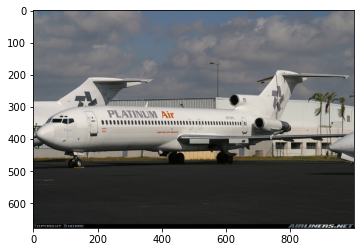

In [22]:
show_image(manufacturer_df,42,'manufacturer')

Boeing 707


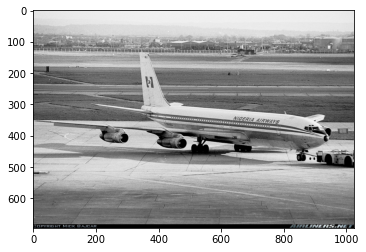

In [23]:
show_image(build_image_database(DATA_BASE_DIR/'images_family_train.txt','family'),24,'family')

In [24]:
manufacturer_df["image_shape"] =manufacturer_df["path"].apply(lambda p: plt.imread(p).shape)

In [25]:
manufacturer_df["image_shape"].apply(lambda x: x[0]).value_counts()

695     627
812     310
678     271
679     186
694     107
       ... 
845       1
1180      1
1149      1
885       1
482       1
Name: image_shape, Length: 404, dtype: int64

In [26]:
manufacturer_df["image_shape"].apply(lambda x: x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: image_shape, Length: 73, dtype: int64

# Constante

In [27]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=IMAGE_WIDTH
IMAGE_DEPTH = 3

In [28]:
def load_resize_image(path,height,width):
    """Load an image and resize it to the target size

    Parameters:
        - path (Path): path to the file to load and resize
        - height (int): the height of the final resized image
        - width(int): the width of the resized image 
    Return
    ------
    numpy.array containing resized image
    """

    return np.array(Image.open(path).resize((width,height)))

In [29]:
manufacturer_df.head(10).apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

0    [[[219, 219, 219], [219, 219, 219], [219, 219,...
1    [[[212, 212, 212], [220, 220, 220], [196, 196,...
2    [[[131, 167, 205], [134, 168, 206], [134, 168,...
3    [[[48, 63, 68], [49, 64, 69], [50, 64, 69], [4...
4    [[[116, 160, 231], [116, 160, 232], [116, 161,...
5    [[[202, 202, 202], [202, 202, 202], [201, 201,...
6    [[[37, 93, 129], [37, 94, 129], [38, 94, 129],...
7    [[[171, 171, 171], [172, 172, 172], [172, 172,...
8    [[[192, 190, 195], [192, 190, 195], [193, 191,...
9    [[[107, 140, 156], [109, 141, 158], [110, 143,...
dtype: object

In [30]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

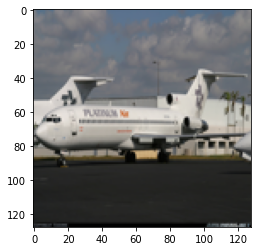

In [31]:
plt.imshow(manufacturer_df.loc[42,'resized_image'])

In [32]:
def build_classification_model(df: pd.DataFrame,target: str, images: str):
    """Build a tensorflow model using information from target and images columns in dataframes
    Parameters
    ----------
        - df (pandas.dataFrame): dataframe with target and images columns
        - target (str): column name for target variable
        - images (str): column name for images
    Returns
    ------
    tensorflow model built & compiled
    """
    
    #Compute number of classes for output layer
    nb_classes = df[target].nunique()
    
    # Computer images size for input layer
    size = df[images].iloc[0].shape
    
    # Building the model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(nb_classes , activation='softmax'))

    #Compilation of the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #output layer of nb_classes
    
    return model

In [33]:
build_classification_model(manufacturer_df,'manufacturer','resized_image')

2022-04-06 16:49:33.056141: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-06 16:49:33.057921: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 16:49:33.059823: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [34]:
# Compute the number of classes to shape the output layer
nb_classes = manufacturer_df.manufacturer.nunique()
nb_classes

30

In [35]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_DEPTH)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes , activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #output layer of nb_classes


In [36]:
y=tf.keras.utils.to_categorical (manufacturer_df['manufacturer'].astype('category').cat.codes)

# Build train & Test set

In [37]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str, stratify: str=None):
    """build x tensor and y tensor for model fitting.
    parameters
    ----------
    df(pd.DataFrame): dataframe 
    target(str): name of target column
    images (str): name of images column
        
    Returns
    -------
    
    x (numpy.array): tensor of x values
    y (numpy.array): tensor of y values
    """
    
    x= np.array(df[images].to_list())
    y=tf.keras.utils.to_categorical (df[target].astype('category').cat.codes)
    return x,y

In [38]:
X_train, X_test,y_train,y_test =  train_test_split(manufacturer_df[['resized_image',"manufacturer"]],y,test_size=0.2,stratify=manufacturer_df['manufacturer'])

In [39]:
assert X_train.shape[0]+X_test.shape[0]== manufacturer_df.shape[0]
assert y_train.shape[0]+y_test.shape[0]== y.shape[0]

In [41]:
X_train['manufacturer'].value_counts(normalize=True)

Boeing                      0.219723
Airbus                      0.130109
Embraer                     0.069741
McDonnell Douglas           0.069741
de Havilland                0.050244
Canadair                    0.040120
Douglas Aircraft Company    0.039745
Cessna                      0.039745
British Aerospace           0.039745
Fokker                      0.029996
Lockheed Corporation        0.020247
Saab                        0.020247
Beechcraft                  0.020247
Gulfstream Aerospace        0.020247
Dassault Aviation           0.020247
Tupolev                     0.019873
ATR                         0.019873
Lockheed Martin             0.010124
Dornier                     0.010124
Fairchild                   0.010124
Piper                       0.010124
Antonov                     0.010124
Cirrus Aircraft             0.010124
Panavia                     0.010124
Yakovlev                    0.010124
Bombardier Aerospace        0.010124
Supermarine                 0.009749
R

In [42]:
X_test['manufacturer'].value_counts(normalize=True)

Boeing                      0.220390
Airbus                      0.130435
Embraer                     0.070465
McDonnell Douglas           0.068966
de Havilland                0.049475
Cessna                      0.040480
Canadair                    0.040480
Douglas Aircraft Company    0.040480
British Aerospace           0.040480
Fokker                      0.029985
Lockheed Corporation        0.020990
ATR                         0.019490
Beechcraft                  0.019490
Dassault Aviation           0.019490
Tupolev                     0.019490
Gulfstream Aerospace        0.019490
Saab                        0.019490
Panavia                     0.010495
Robin                       0.010495
Ilyushin                    0.010495
Lockheed Martin             0.010495
Supermarine                 0.010495
Eurofighter                 0.010495
Antonov                     0.010495
Dornier                     0.010495
Yakovlev                    0.010495
Piper                       0.008996
B

# Train model 

In [43]:
%%time 
epochs = 5
history = model.fit(np.array(X_train['resized_image'].to_list()),y_train,batch_size = 32,epochs = epochs , validation_data = (np.array(X_test['resized_image'].to_list()),y_test))

2022-04-06 16:50:13.192292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-06 16:50:13.213452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2370380000 Hz


Epoch 1/5
84/84 [==============================] - 62s 730ms/step - loss: 56.6569 - accuracy: 0.1560 - val_loss: 2.8989 - val_accuracy: 0.2204
Epoch 2/5
84/84 [==============================] - 63s 751ms/step - loss: 2.9785 - accuracy: 0.2134 - val_loss: 2.8926 - val_accuracy: 0.2204
Epoch 3/5
84/84 [==============================] - 62s 743ms/step - loss: 2.9632 - accuracy: 0.1981 - val_loss: 2.8908 - val_accuracy: 0.2204
Epoch 4/5
84/84 [==============================] - 62s 742ms/step - loss: 2.9527 - accuracy: 0.2035 - val_loss: 2.8885 - val_accuracy: 0.2204
Epoch 5/5
84/84 [==============================] - 62s 738ms/step - loss: 2.9454 - accuracy: 0.2073 - val_loss: 2.8876 - val_accuracy: 0.2204
CPU times: user 19min 15s, sys: 8min 11s, total: 27min 27s
Wall time: 5min 12s


In [44]:
#Load train & test dataset
train_df = build_image_database(DATA_BASE_DIR/'images_manufacturer_train.txt','manufacturer')
test_df = build_image_database(DATA_BASE_DIR/'images_manufacturer_test.txt','manufacturer')

train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

#Build tensors for training & testing
X_train,y_train = build_x_and_y(train_df,'manufacturer','resized_image')
X_test,y_test = build_x_and_y(test_df,'manufacturer','resized_image')

model = build_classification_model(train_df,"manufacturer","resized_image")

In [46]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

!rm -rf ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2022-04-06 16:58:44.636358: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-06 16:58:44.636397: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-06 16:58:44.636433: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [47]:
%%time 
epochs = 5
history = model.fit(X_train,y_train,batch_size = 32,epochs = epochs , validation_data = (X_test,y_test),
                   callbacks=[tensorboard_callback]
                   )

Epoch 1/5
  1/105 [..............................] - ETA: 3:22 - loss: 61.7683 - accuracy: 0.0000e+00

2022-04-06 16:58:51.401772: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-06 16:58:51.402069: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


  2/105 [..............................] - ETA: 1:24 - loss: 125.5768 - accuracy: 0.0000e+00

2022-04-06 16:58:52.207298: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-06 16:58:52.211759: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-06 16:58:52.215092: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220406-165844/train/plugins/profile/2022_04_06_16_58_52
2022-04-06 16:58:52.216032: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220406-165844/train/plugins/profile/2022_04_06_16_58_52/rich-pc.trace.json.gz
2022-04-06 16:58:52.221350: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220406-165844/train/plugins/profile/2022_04_06_16_58_52
2022-04-06 16:58:52.223805: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220406-165844/train/plugins/profile/2022_04_06_1

105/105 [==============================] - 90s 845ms/step - loss: 23.6739 - accuracy: 0.1637 - val_loss: 2.8461 - val_accuracy: 0.2199
Epoch 2/5
105/105 [==============================] - 90s 863ms/step - loss: 2.8310 - accuracy: 0.2143 - val_loss: 2.7308 - val_accuracy: 0.2208
Epoch 3/5
105/105 [==============================] - 89s 846ms/step - loss: 2.5245 - accuracy: 0.2667 - val_loss: 2.6859 - val_accuracy: 0.2478
Epoch 4/5
105/105 [==============================] - 93s 886ms/step - loss: 2.1923 - accuracy: 0.3507 - val_loss: 2.5187 - val_accuracy: 0.2718
Epoch 5/5
105/105 [==============================] - 90s 860ms/step - loss: 1.7263 - accuracy: 0.4739 - val_loss: 2.5655 - val_accuracy: 0.2670
CPU times: user 28min 54s, sys: 12min 12s, total: 41min 7s
Wall time: 7min 35s


In [49]:
%tensorboard  --logdir  logs/fit 

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/home/rich229/anaconda3/envs/planes/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/tensorboard/default.py", line 108, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/tensorboard/default.py", line 143, in get_dynamic_plugins
    return [
  File "/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/tensorboard/default.py", line 144, in <listcomp>
    entry_point.load()
  File "/home/rich229/anaconda3/envs/planes/lib/python3.8/site-packages/pkg_resources/__init__.py", line 2449, in load
    self.require(*args, **kwargs)
  File "/home/rich229/an

In [50]:
model.predict(X_test[10:11])

array([[1.7518276e-02, 2.9590034e-01, 4.6735592e-03, 7.9826539e-04,
        5.4559368e-01, 8.9802161e-05, 8.3467187e-03, 1.6222062e-03,
        9.7009586e-04, 9.6257965e-05, 3.5461059e-04, 3.6088304e-04,
        4.2280238e-03, 6.1891392e-02, 2.0876590e-03, 2.1656409e-04,
        1.4220512e-03, 8.7559776e-04, 3.5814408e-03, 6.8325335e-03,
        1.8812669e-04, 3.6909278e-02, 6.4304791e-04, 1.0385213e-04,
        1.7296420e-04, 8.7670743e-04, 4.0465886e-05, 1.5282579e-03,
        1.2805876e-03, 7.9681841e-04]], dtype=float32)

Boeing


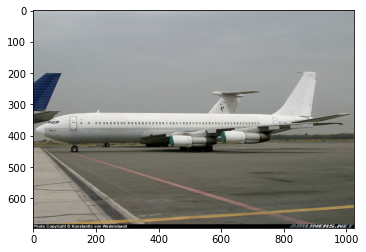

In [51]:
show_image(test_df,10,'manufacturer')

In [52]:
np.argmax(model.predict(X_test[10:20]),axis=1)

array([ 4,  4,  4,  0,  4,  4,  4,  4, 29,  4])

In [53]:
def classify_images(images,model,classes_names=None)->int:
    """Classify images through a tensorflow model.
    
    Parameters:
    -----------
    
    images(np.array): set of images to classify
    model (tensorflow.keras.Model): tensorflow/keras model
    
    Returns
    -------
    predicted classes 
    
    """
    
    results = model.predict(images)
    classes = np.argmax(results,axis=1)
    if classes_names is not None:
        classes = np.array(classes_names[classes])
    return classes

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

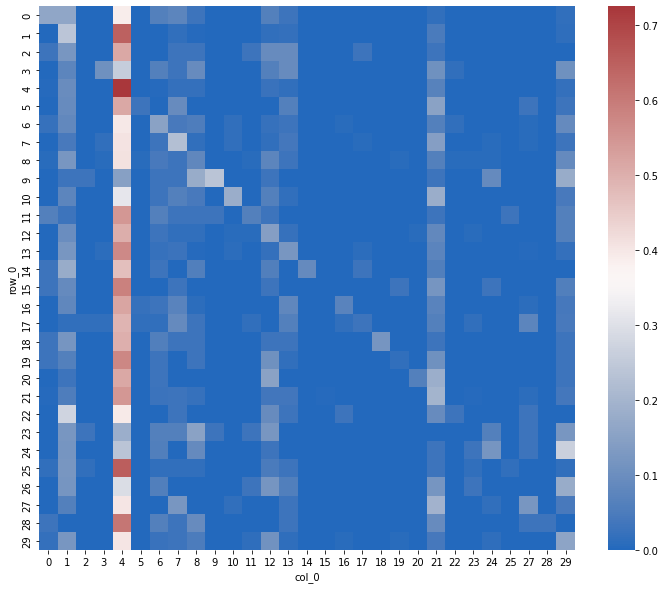

In [56]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_test,axis=1),classify_images(X_test,model), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='manufacturer'>

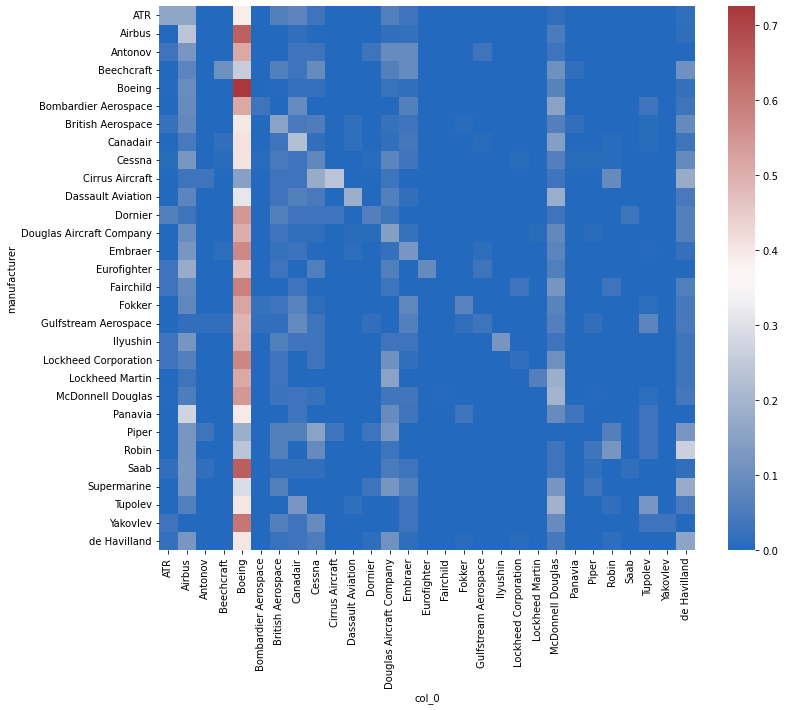

In [57]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df['manufacturer'],classify_images(X_test,model,test_df['manufacturer'].astype('category').cat.categories), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

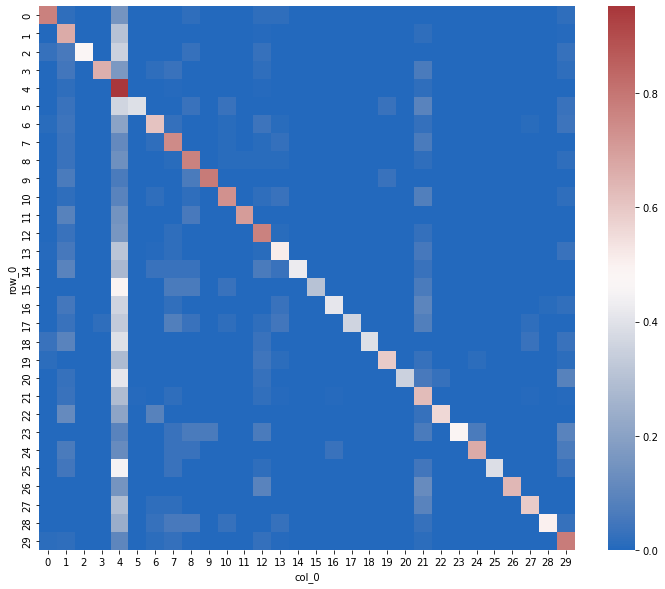

In [58]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(np.argmax(y_train,axis=1),classify_images(X_train,model), normalize='index'), cmap='vlag', ax=ax)

<AxesSubplot:xlabel='col_0', ylabel='manufacturer'>

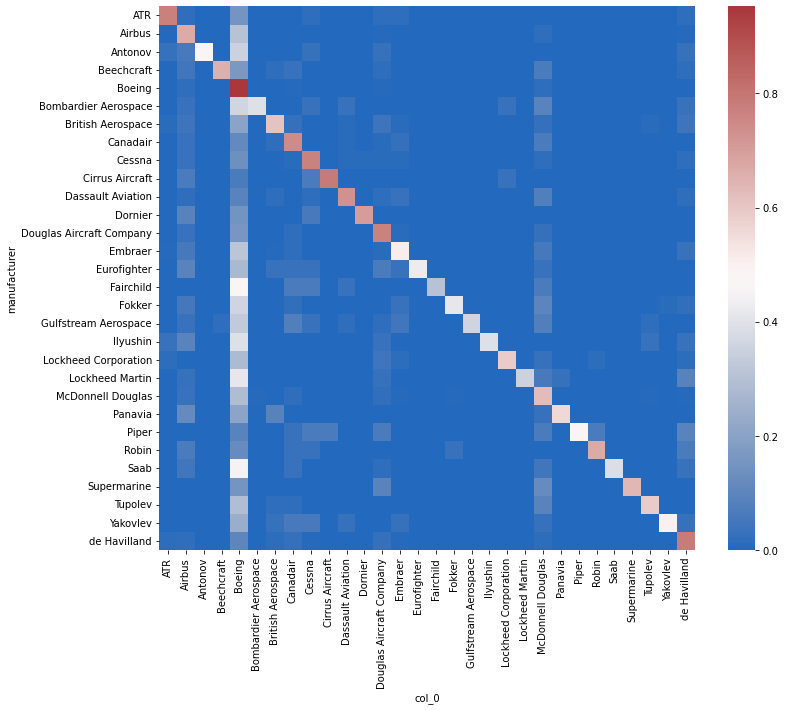

In [59]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(train_df['manufacturer'],classify_images(X_train,model,train_df['manufacturer'].astype('category').cat.categories), normalize='index'), cmap='vlag', ax=ax)

In [60]:
def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return

In [63]:
model.save("../model/my_model.h5")

In [64]:
reloaded_model = load_model('../model/my_model.h5')

In [65]:
np.argmax(reloaded_model.predict(X_test[10:20]), axis=1)

array([ 4,  4,  4,  0,  4,  4,  4,  4, 29,  4])